In [24]:
# imports
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

#Move to parent folder
sys.path.insert(0, '../croprows-cli/src/')


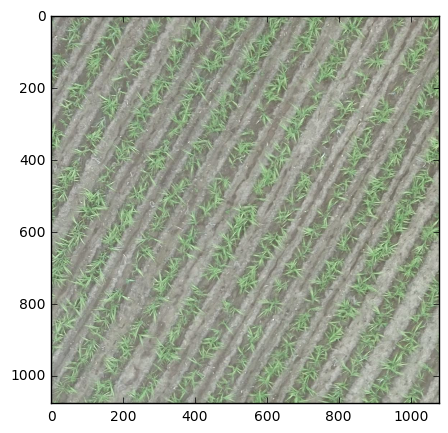

In [25]:
img_url = "../orthomosaics/results/testfile3/mosaic_5_5_1077px_25_tiles/mosaic-cl_3-rw_2.jpg"
#img_url = "../orthomosaics/results/testfile7/mosaic_10_8_1339px_80_tiles/mosaic-cl_3-rw_2.jpg"
img_read = cv2.imread(img_url)
plt.figure(figsize=(5, 5))
plt.imshow(img_read)
plt.show()

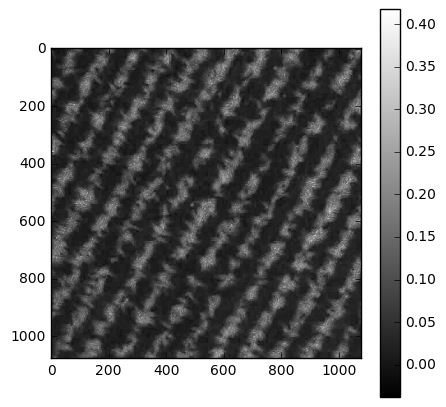

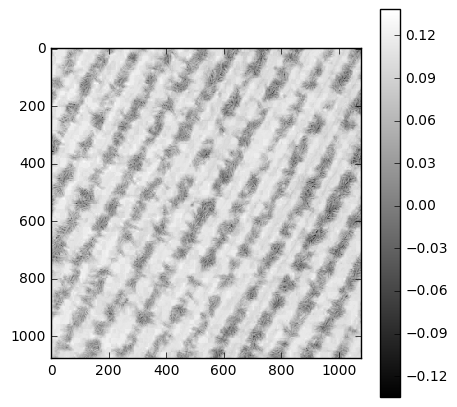

In [26]:
##ExG 
def calc_ExG(image_in):
    B,G,R = cv2.split(image_in)
    R_ = R/255
    G_ = G/255
    B_ = B/255
    r= R_/(R_+G_+B_)
    g= G_/(R_+G_+B_)
    b= B_/(R_+G_+B_)
    return (2*g - r - b)

##ExR 
def calc_ExR(image_in):
    B, G, R = cv2.split(image_in)
    R_ = R/255
    G_ = G/255
    B_ = B/255
    r= R_/(R_+G_+B_)
    g= G_/(R_+G_+B_)
    b= B_/(R_+G_+B_)
    return (1.4*r - g)


cexg = calc_ExG(img_read)
plt.figure(figsize=(5, 5))
plt.imshow(cexg,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

cexr = calc_ExR(img_read)
plt.figure(figsize=(5, 5))
plt.imshow(cexr,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

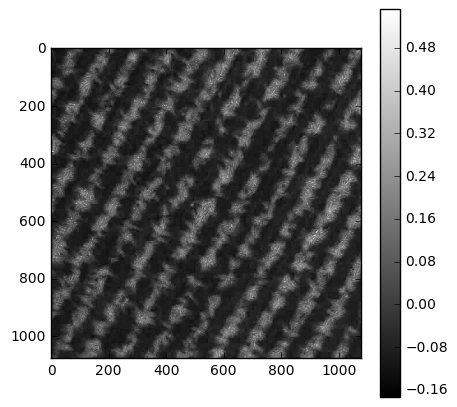

In [27]:
tmp_dif_exgexr = cexg- cexr
plt.figure(figsize=(5, 5))
plt.imshow(tmp_dif_exgexr,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

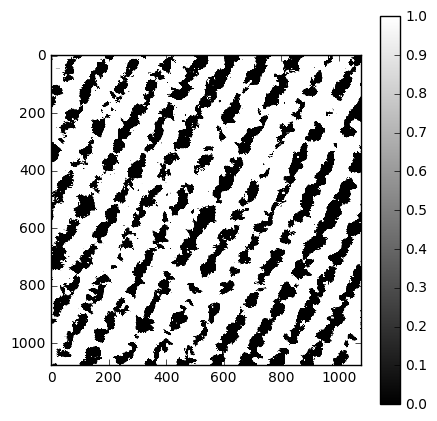

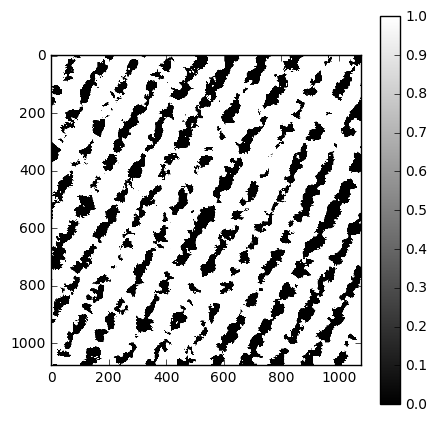

In [28]:
arr = np.uint8(cexg*255)
ret, thres1 =cv2.threshold(arr, 0, 1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#cv2.threshold(arr, 0, 1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(5, 5))
plt.imshow(thres1,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(thres1,kernel,iterations = 1)


plt.figure(figsize=(5, 5))
plt.imshow(dilation,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

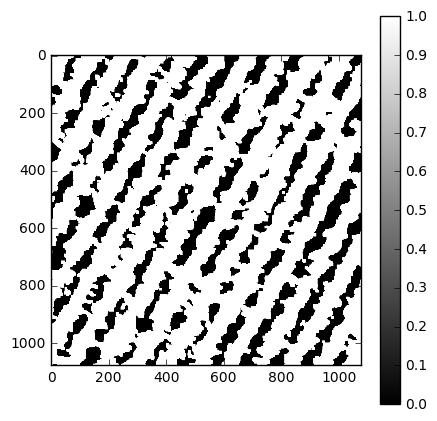

In [47]:
kernel = np.ones((9,9),np.uint8)
opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(5, 5))
plt.imshow(opening,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

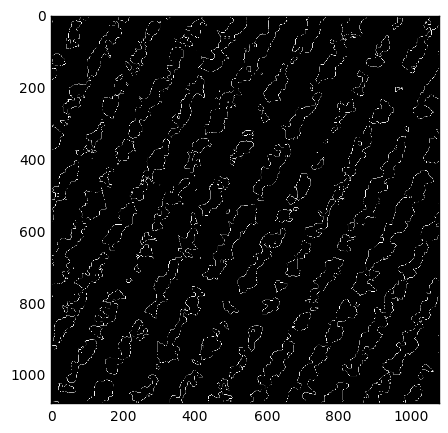

In [30]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

autocanny = auto_canny(opening)

plt.figure(figsize=(5, 5))
plt.imshow(autocanny,cmap=plt.get_cmap('gray'))
plt.show()

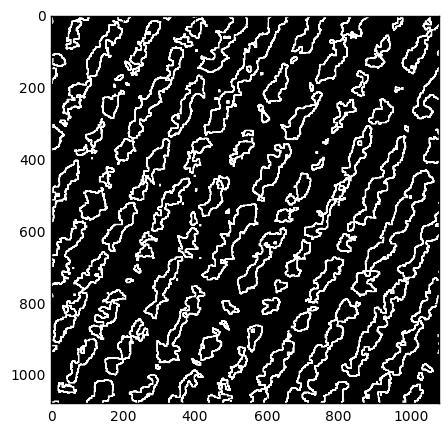

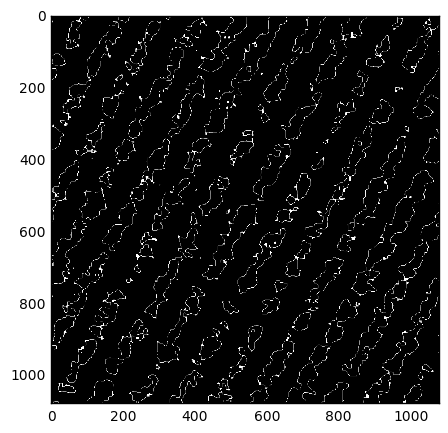

In [31]:
kernel = np.ones((3,3), np.uint8)  
d_im = cv2.dilate(autocanny, kernel, iterations=2)
e_im = cv2.erode(d_im, kernel, iterations=2)

plt.figure(figsize=(5, 5))
plt.imshow(d_im,cmap=plt.get_cmap('gray'))
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(e_im,cmap=plt.get_cmap('gray'))
plt.show()

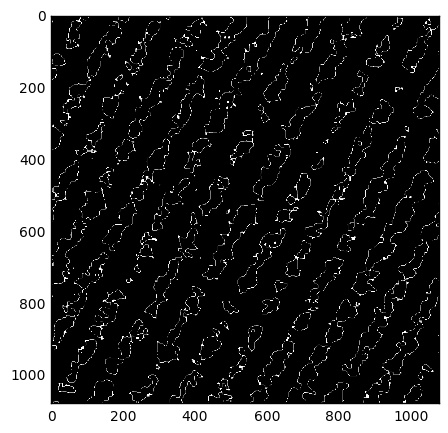

In [32]:
def find_skeleton3(img):
    skeleton = np.zeros(img.shape,np.uint8)
    eroded = np.zeros(img.shape,np.uint8)
    temp = np.zeros(img.shape,np.uint8)
    _,thresh = cv2.threshold(img,127,255,0)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(9,9))
    iters = 0
    while(True):
        cv2.erode(thresh, kernel, eroded)
        cv2.dilate(eroded, kernel, temp)
        cv2.subtract(thresh, temp, temp)
        cv2.bitwise_or(skeleton, temp, skeleton)
        thresh, eroded = eroded, thresh # Swap instead of copy
        iters += 1
        if cv2.countNonZero(thresh) == 0:
            return (skeleton,iters)

sk, ite = find_skeleton3(e_im)      
plt.figure(figsize=(5, 5))
plt.imshow(sk,cmap=plt.get_cmap('gray'))
plt.show()

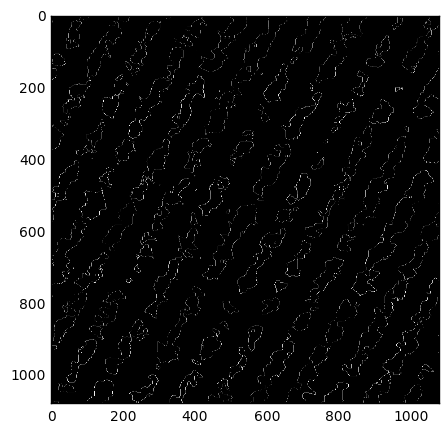

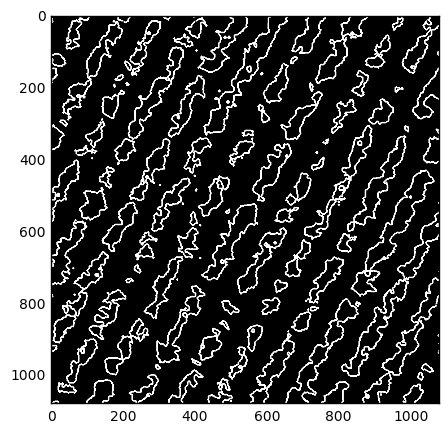

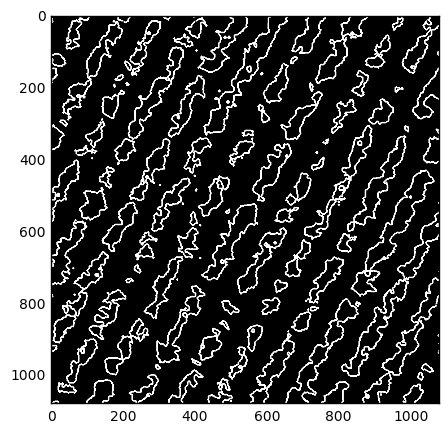

In [33]:
copy_autocanny = autocanny.copy()

img2, contours, hierarchy = cv2.findContours(copy_autocanny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.figure(figsize=(5, 5))
plt.imshow(img2,cmap=plt.get_cmap('gray'))
plt.show()

imgcont = cv2.drawContours(copy_autocanny, contours, -1, (255,255,255), 3)

plt.figure(figsize=(5, 5))
plt.imshow(imgcont,cmap=plt.get_cmap('gray'))
plt.show()

for c in contours:
    # find bounding box coordinates
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_read, (x,y), (x+w, y+h), (0, 255, 0), 2)
    # find minimum area
    rect = cv2.minAreaRect(c)
    # calculate coordinates of the minimum area rectangle
    box = cv2.boxPoints(rect)
    # normalize coordinates to integers
    box = np.int0(box)
    # draw contours
    cv2.drawContours(img_read, [box], 0, (0,0, 255), 3)
    # calculate center and radius of minimum enclosing circle
    #(x,y),radius = cv2.minEnclosingCircle(c)
    # cast to integers
    #center = (int(x),int(y))
    #radius = int(radius)
    # draw the circle
    #imgcc = cv2.circle(img_read,center,radius,(0,255,0),2)
    #cv2.drawContours(imgcc, contours, -1, (255, 0, 0), 1)
    
plt.figure(figsize=(5, 5))
plt.imshow(imgcont,cmap=plt.get_cmap('gray'))
plt.show()


In [34]:
########################################### HOUGH LINES FROM SCRATCH USING NUMPY
# Step 1: The Hough transform needs a binary edges images.  For this particular
# python file, I used the openCV built in Class Canny to create this edge image
# from the original shapes.png file.

# This is the function that will build the Hough Accumulator for the given image
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes
    
    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]
        
        #print(H)

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) + y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1
    
    return H, rhos, thetas

In [35]:
# This is a simple peaks function that just finds the indicies of the number
# of maximum values equal to num_peaks.  You have to be careful here though, if
# there's any noise in the image it will like create a 'pocket' of local maxima
# values.  This function ignores this and in turn has the tendancy to return
# multiple lines along an actual line in the image.
def hough_simple_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T

In [36]:
# This more advance Hough peaks funciton has threshold and nhood_size arguments
# threshold will threshold the peak values to be above this value if supplied,
# where as nhood_size will surpress the surrounding pixels centered around
# the local maximum after that value has been assigned as a peak.  This will
# force the algorithm to look eslwhere after it's already selected a point from
# a 'pocket' of local maxima.
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        print(min_x)
        print(max_x)
        for x in range(int(min_x), int(max_x)):
            for y in range(int(min_y), int(max_y)):
                # remove neighborhoods in H1
                H1[y, x] = 0
                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                    if (y == min_y or y == (max_y - 1)):
                        H[y, x] = 255
    # return the indicies and the original Hough space with selected points
    return indicies, H

In [37]:
# a simple funciton used to plot a Hough Accumulator
def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
    ''' A function that plot a Hough Space using Matplotlib. '''
    fig = plt.figure(figsize=(10, 10))
    fig.canvas.set_window_title(plot_title)
    plt.imshow(H, cmap='jet')
    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()

In [38]:
# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    print(indicies)
    print(len(indicies))
    
    print(rhos)
    print(thetas)
    
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        print(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [39]:
# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(sk)

In [40]:
print(H)
print(rhos)
print(thetas)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[-1524. -1523. -1522. ...,  1522.  1523.  1524.]
[-1.57079633 -1.55334303 -1.53588974 -1.51843645 -1.50098316 -1.48352986
 -1.46607657 -1.44862328 -1.43116999 -1.41371669 -1.3962634  -1.37881011
 -1.36135682 -1.34390352 -1.32645023 -1.30899694 -1.29154365 -1.27409035
 -1.25663706 -1.23918377 -1.22173048 -1.20427718 -1.18682389 -1.1693706
 -1.15191731 -1.13446401 -1.11701072 -1.09955743 -1.08210414 -1.06465084
 -1.04719755 -1.02974426 -1.01229097 -0.99483767 -0.97738438 -0.95993109
 -0.9424778  -0.9250245  -0.90757121 -0.89011792 -0.87266463 -0.85521133
 -0.83775804 -0.82030475 -0.80285146 -0.78539816 -0.76794487 -0.75049158
 -0.73303829 -0.71558499 -0.6981317  -0.68067841 -0.66322512 -0.64577182
 -0.62831853 -0.61086524 -0.59341195 -0.57595865 -0.55850536 -0.54105207
 -0.52359878 -0.50614548 -0.48869219 -0.4712389  -0.45378561 -0.43633231
 -0.41887902 -0.40142

In [41]:
indicies, H = hough_peaks(H,3, nhood_size=11) # find peaks
print(indicies)
print(H)

114.5
126.5
115.5
127.5
116.5
128.5
[(2288, 120), (2463, 121), (2087, 122)]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


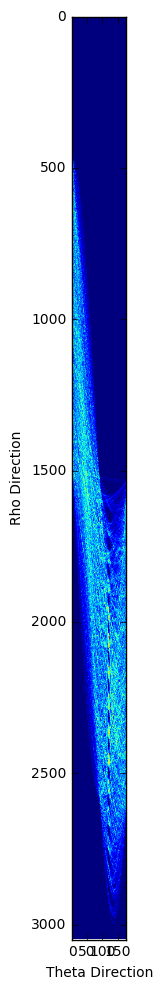

In [42]:
plot_hough_acc(H) # plot hough space, brighter spots have higher votes

In [43]:
img_read = cv2.imread(img_url)
hough_lines_draw(img_read, indicies, rhos, thetas)

[(2288, 120), (2463, 121), (2087, 122)]
3
[-1524. -1523. -1522. ...,  1522.  1523.  1524.]
[-1.57079633 -1.55334303 -1.53588974 -1.51843645 -1.50098316 -1.48352986
 -1.46607657 -1.44862328 -1.43116999 -1.41371669 -1.3962634  -1.37881011
 -1.36135682 -1.34390352 -1.32645023 -1.30899694 -1.29154365 -1.27409035
 -1.25663706 -1.23918377 -1.22173048 -1.20427718 -1.18682389 -1.1693706
 -1.15191731 -1.13446401 -1.11701072 -1.09955743 -1.08210414 -1.06465084
 -1.04719755 -1.02974426 -1.01229097 -0.99483767 -0.97738438 -0.95993109
 -0.9424778  -0.9250245  -0.90757121 -0.89011792 -0.87266463 -0.85521133
 -0.83775804 -0.82030475 -0.80285146 -0.78539816 -0.76794487 -0.75049158
 -0.73303829 -0.71558499 -0.6981317  -0.68067841 -0.66322512 -0.64577182
 -0.62831853 -0.61086524 -0.59341195 -0.57595865 -0.55850536 -0.54105207
 -0.52359878 -0.50614548 -0.48869219 -0.4712389  -0.45378561 -0.43633231
 -0.41887902 -0.40142573 -0.38397244 -0.36651914 -0.34906585 -0.33161256
 -0.31415927 -0.29670597 -0.279252

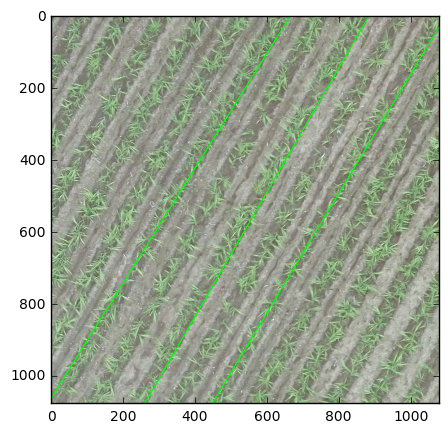

In [44]:
# Show image with manual Hough Transform Lines
plt.figure(figsize=(5, 5))
plt.imshow(img_read)
plt.show()

In [45]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

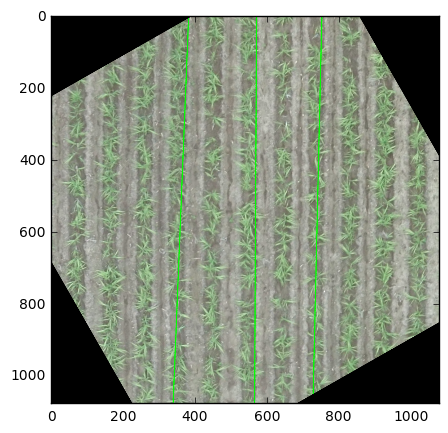

In [46]:
rotate = rotateImage(img_read,(0.53*np.pi*180)+90)
plt.figure(figsize=(5, 5))
plt.imshow(rotate)
plt.show()